In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from words import *

# Get data

In [4]:
MAX_LEN = 15

In [5]:
languages = sorted(['en', 'de', 'fr', 'it', 'sp'])
languages

['de', 'en', 'fr', 'it', 'sp']

In [6]:
filepaths = get_filepaths(*languages)
df = read_data(filepaths)
df = filter_data(df, min_len=4, max_len=MAX_LEN, min_freq=5)
df.language = df.language.str.slice(0, 2)

In [7]:
df.head()

,word,freq,language
37,wurde,1463,de
46,sich,1066,de
47,eine,1049,de
53,auch,662,de
55,nach,653,de


In [8]:
df.groupby('language').size()

language
de    3104
en    4613
fr    4079
it    4480
sp    4312
dtype: int64

### Remove duplicate words across languages

In [9]:
joined = df.merge(df, on=['word'])
joined = joined[joined.language_x != joined.language_y]
duplicate_words = list(set(joined.word))
print(duplicate_words)

['periodico', 'separation', 'tecnico', 'fallen', 'musicales', 'cancer', 'europa', 'situation', 'stadium', 'america', 'rare', 'winter', 'explosion', 'jimmy', 'orange', 'solamente', 'gran', 'xvii', 'frase', 'mediante', 'north', 'artistica', 'sola', 'citation', 'cambia', 'sciences', 'jersey', 'consiste', 'samuel', 'video', 'india', 'provoca', 'edificio', 'maria', 'tunnel', 'records', 'mille', 'totale', 'desire', 'total', 'convento', 'fisica', 'geografica', 'manuel', 'temple', 'coach', 'symbol', 'intento', 'forme', 'permanente', 'figure', 'representation', 'young', 'alliance', 'error', 'miller', 'peso', 'stephen', 'centrale', 'kong', 'soldat', 'dirige', 'guide', 'conserva', 'williams', 'basse', 'martin', 'section', 'natural', 'vide', 'observation', 'theme', 'factor', 'capitale', 'biblioteca', 'solution', 'will', 'discussion', 'organo', 'port', 'lieutenant', 'state', 'homer', 'part', 'prove', 'series', 'california', 'christian', 'films', 'enorme', 'fondo', 'navy', 'relief', 'bombe', 'steve'

In [10]:
df = df[~df.word.isin(duplicate_words)]

In [11]:
df.groupby('language').size()

language
de    2795
en    3606
fr    3159
it    3694
sp    3482
dtype: int64

### Remove duplicate words within languages

In [12]:
df = df.drop_duplicates('word')

In [13]:
assert len(df.word) == len(set(df.word))

In [14]:
df.groupby('language').size()

language
de    2623
en    3387
fr    2922
it    3483
sp    3199
dtype: int64

### Get validation indices

In [15]:
df = df.reset_index(drop=True)

In [16]:
train_idxs, val_idxs = train_test_split(df.index.tolist(), train_size=0.5, random_state=1)

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Get letters as features

In [17]:
feats = extract_features(df)

In [18]:
feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,language
0,w,u,r,d,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
1,s,i,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
2,e,i,n,e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
3,a,u,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de
4,n,a,c,h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,de


# One-encoded features model

In [19]:
from fastai.structured import *
from fastai.column_data import *

### Dumify variables

In [20]:
def gen_dummy_cols():
    for i in range(MAX_LEN):
        for c_i in range(ord('a'), ord('z') + 1):
            c = chr(c_i)
            yield f'{i}_{c}'
        yield f'{i}_nan'

dummy_cols = list(gen_dummy_cols())

In [21]:
print(dummy_cols[:30])
print(dummy_cols[-30:])

['0_a', '0_b', '0_c', '0_d', '0_e', '0_f', '0_g', '0_h', '0_i', '0_j', '0_k', '0_l', '0_m', '0_n', '0_o', '0_p', '0_q', '0_r', '0_s', '0_t', '0_u', '0_v', '0_w', '0_x', '0_y', '0_z', '0_nan', '1_a', '1_b', '1_c']
['13_y', '13_z', '13_nan', '14_a', '14_b', '14_c', '14_d', '14_e', '14_f', '14_g', '14_h', '14_i', '14_j', '14_k', '14_l', '14_m', '14_n', '14_o', '14_p', '14_q', '14_r', '14_s', '14_t', '14_u', '14_v', '14_w', '14_x', '14_y', '14_z', '14_nan']


In [22]:
y = feats['language']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(np.float32).reset_index(drop=True)

In [23]:
feats_no_label = feats.drop('language', axis=1)

In [24]:
feats_dummy = pd.get_dummies(feats, dummy_na=True)
feats_dummy = feats_dummy.T.reindex(dummy_cols).T.fillna(0)
feats_dummy = feats_dummy.astype(np.float32).reset_index(drop=True)

In [25]:
feats_dummy.head()

,0_a,0_b,0_c,0_d,0_e,0_f,0_g,0_h,0_i,0_j,...,14_r,14_s,14_t,14_u,14_v,14_w,14_x,14_y,14_z,14_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
y_dummy.head()

,de,en,fr,it,sp
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


### Model

In [27]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df=feats_dummy, y=y_dummy.values, cat_flds=[], bs=128,
                                       is_reg=False, is_multi=True)

In [28]:
learn = md.get_learner(emb_szs=[], n_cont=feats_dummy.shape[1], emb_drop=0, out_sz=len(languages),
                       szs=[500], drops=[0.3])

In [29]:
learn.lr_find()

epoch      trn_loss   val_loss                              
    0      1.092242   9.152957  



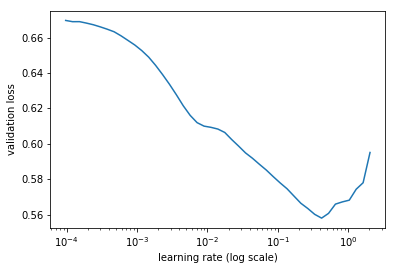

In [30]:
learn.sched.plot()

In [31]:
def accuracy(preds, targs):
    _, preds = torch.max(preds, dim=1)
    _, targs = torch.max(targs, dim=1)
    return (preds==targs).float().mean()

In [32]:
learn.fit(0.1, n_cycle=3, cycle_len=15, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      0.50443    0.424034   0.465864  
    1      0.444395   0.41479    0.497118                   
    2      0.41043    0.402364   0.524273                   
    3      0.375714   0.386784   0.557064                   
    4      0.343742   0.375625   0.580505                   
    5      0.309832   0.368679   0.601896                   
    6      0.286947   0.362645   0.61304                    
    7      0.260903   0.35981    0.626617                   
    8      0.235565   0.364983   0.637889                   
    9      0.214311   0.373052   0.638145                   
    10     0.196142   0.375251   0.648649                   
    11     0.18362    0.376613   0.648777                   
    12     0.174032   0.37705    0.64788                    
    13     0.168709   0.378373   0.650954                   
    14     0.164554   0.378486   0.650698                   
    15     0.237851   0.413599   0.585884

[array([0.76317]), 0.6442935826822083]

### Predict and enrich validation dataset for analysis

In [33]:
df_val = df.iloc[val_idxs]

In [34]:
labels = np.argmax(y_dummy.iloc[val_idxs].values, axis=1)
df_val['language_id'] = labels

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
preds_dummy = learn.predict_array(x_cat=[0], x_cont=feats_dummy.iloc[val_idxs])
preds = np.argmax(preds_dummy, axis=1)
probas = np.max(preds_dummy, axis=1)
df_val['pred_id'] = preds
df_val['probas'] = probas

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [36]:
df_val['pred'] = df_val['pred_id'].map(dict(enumerate(languages)))

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Results analysis

In [37]:
# Most confident predictions
df_val.sort_values('probas', ascending=False).head(10)

,word,freq,language,language_id,pred_id,probas,pred
259,kleinen,35,de,0,0,1.0,de
11154,adaptations,6,en,1,2,1.0,fr
12712,attorno,21,it,3,3,1.0,it
9283,hydrogen,25,en,1,0,1.0,de
10558,approaches,8,en,1,2,1.0,fr
9799,markets,14,en,1,1,1.0,en
12130,yields,5,en,1,1,1.0,en
3787,mexique,10,fr,2,2,1.0,fr
1831,entlassung,6,de,0,0,1.0,de
12739,secoli,21,it,3,3,1.0,it


In [38]:
# Least confident predictions
df_val.sort_values('probas').head(10)

,word,freq,language,language_id,pred_id,probas,pred
10295,relationships,10,en,1,0,7.103497e-10,de
12438,probabilmente,34,it,3,2,4.596022e-07,fr
13455,professionista,11,it,3,3,9.136772e-07,it
1995,beeinflusst,6,de,0,2,5.134277e-06,fr
1131,ausgeschlossen,10,de,0,4,1.422097e-05,sp
3144,allemande,20,fr,2,4,1.029879e-04,sp
11772,evaluation,5,en,1,4,2.869701e-04,sp
11136,pennsylvania,6,en,1,3,3.242664e-04,it
3792,allemandes,10,fr,2,4,3.260454e-04,sp
4779,intermediaire,6,fr,2,4,5.023709e-04,sp


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [40]:
cm = confusion_matrix(df_val['language'], df_val['pred'])

Confusion matrix, without normalization
[[ 921  183  137   53   43]
 [ 141 1051  284  119  127]
 [  94  220  903  159   92]
 [  45   74  177 1175  256]
 [  41   98  180  254  980]]


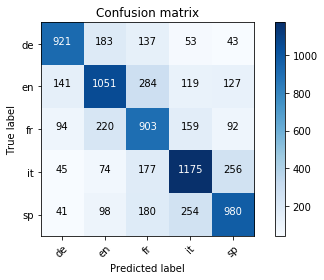

In [41]:
plot_confusion_matrix(cm, languages)

Normalized confusion matrix
[[0.68886 0.13687 0.10247 0.03964 0.03216]
 [0.08188 0.61034 0.16492 0.06911 0.07375]
 [0.06403 0.14986 0.61512 0.10831 0.06267]
 [0.02606 0.04285 0.10249 0.68037 0.14823]
 [0.0264  0.0631  0.1159  0.16355 0.63104]]


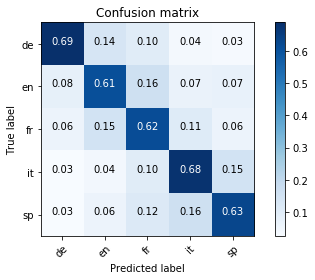

In [42]:
plot_confusion_matrix(cm, languages, normalize=True)

# Embedded features model

In [43]:
data, y_idxs, _ = proc_df(feats, 'language')

In [44]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,23,21,18,4,5,0,0,0,0,0,0,0,0,0,0
1,19,9,3,8,0,0,0,0,0,0,0,0,0,0,0
2,5,9,14,5,0,0,0,0,0,0,0,0,0,0,0
3,1,21,3,8,0,0,0,0,0,0,0,0,0,0,0
4,14,1,3,8,0,0,0,0,0,0,0,0,0,0,0


In [45]:
y_idxs

array([0, 0, 0, ..., 3, 3, 3], dtype=int8)

In [46]:
y_dummy = np.zeros((len(y_idxs), len(languages)))
y_dummy[np.arange(len(y_idxs)), y_idxs] = 1

In [47]:
y_dummy

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

### Model

In [66]:
PATH = 'data/words/'
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df=data, y=y_dummy, cat_flds=list(range(MAX_LEN)), bs=128,
                                       is_reg=False, is_multi=True)

In [67]:
cat_sz = [(c, len(feats[c].cat.categories)+1) for c in list(range(MAX_LEN))]

In [68]:
cat_sz

[(0, 27),
 (1, 27),
 (2, 27),
 (3, 27),
 (4, 27),
 (5, 27),
 (6, 27),
 (7, 27),
 (8, 27),
 (9, 27),
 (10, 27),
 (11, 22),
 (12, 20),
 (13, 18),
 (14, 12)]

In [69]:
emb_szs = [(c, 13) for _, c in cat_sz]

In [70]:
learn = md.get_learner(emb_szs, n_cont=0, emb_drop=0.4, out_sz=len(languages), szs=[500], drops=[0.3])

In [71]:
learn.lr_find()

epoch      trn_loss   val_loss                              
    0      1.941549   5.526195  



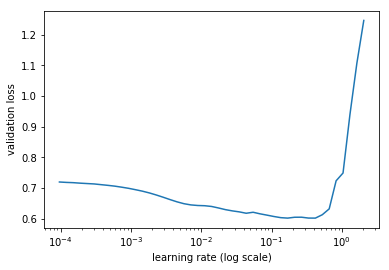

In [72]:
learn.sched.plot()

In [73]:
def accuracy(preds, targs):
    _, preds = torch.max(preds, dim=1)
    _, targs = torch.max(targs, dim=1)
    return (preds==targs).float().mean()

In [74]:
learn.fit(0.01, n_cycle=3, cycle_len=15, cycle_mult=2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      0.630747   0.487675   0.312028  
    1      0.477033   0.388459   0.518637                   
    2      0.413439   0.367346   0.565006                   
    3      0.379994   0.343867   0.608172                   
    4      0.363009   0.334259   0.62508                    
    5      0.347221   0.325059   0.639298                   
    6      0.334123   0.320451   0.636992                   
    7      0.325597   0.311241   0.663251                   
    8      0.316402   0.306298   0.667094                   
    9      0.304867   0.300592   0.671064                   
    10     0.297553   0.300941   0.677725                   
    11     0.29147    0.296426   0.680927                   
    12     0.284726   0.294525   0.68208                    
    13     0.283771   0.294464   0.682849                   
    14     0.282333   0.294317   0.68208                    
    15     0.307871   0.312501   0.655309

[array([0.27887]), 0.7253746637632894]

### Predict and enrich validation dataset for analysis

In [75]:
df_val = df.iloc[val_idxs]

In [76]:
labels = np.argmax(y_dummy[val_idxs], axis=1)
df_val['language_id'] = labels

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [77]:
preds_dummy = learn.predict_array(x_cat=data.iloc[val_idxs], x_cont=[0])
preds = np.argmax(preds_dummy, axis=1)
probas = np.max(preds_dummy, axis=1)
df_val['pred_id'] = preds
df_val['probas'] = probas

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [78]:
df_val['pred'] = df_val['pred_id'].map(dict(enumerate(languages)))

/home/quentin/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Results analysis

In [79]:
# Most confident predictions
df_val.sort_values('probas', ascending=False).head(10)

,word,freq,language,language_id,pred_id,probas,pred
2082,schwedischen,6,de,0,0,1.0,de
4841,olympique,6,fr,2,2,1.0,fr
2168,bestatigung,5,de,0,0,1.0,de
4139,cardiaque,8,fr,2,2,1.0,fr
5310,mecanique,5,fr,2,2,1.0,fr
10700,partially,8,en,1,1,1.0,en
558,erfolgreich,18,de,0,0,1.0,de
11350,hierarchy,6,en,1,1,1.0,en
11783,extensively,5,en,1,1,1.0,en
973,fertigstellung,11,de,0,0,1.0,de


In [80]:
# Least confident predictions
df_val.sort_values('probas').head(10)

,word,freq,language,language_id,pred_id,probas,pred
5122,combinaison,5,fr,2,2,0.104428,fr
11932,overhead,5,en,1,4,0.139182,sp
11935,participating,5,en,1,3,0.154769,it
4688,comparaison,6,fr,2,2,0.158430,fr
10801,achievement,7,en,1,2,0.160486,fr
8987,official,43,en,1,3,0.167275,it
9431,achieve,20,en,1,2,0.168321,fr
10116,greatest,11,en,1,1,0.168377,en
10833,civilian,7,en,1,4,0.170138,sp
9895,mixture,13,en,1,2,0.171346,fr


In [81]:
cm = confusion_matrix(labels, preds)

Confusion matrix, without normalization
[[1003  125  112   59   38]
 [  98 1096  322   94  112]
 [  61  160 1031  155   61]
 [  24   25   90 1397  191]
 [  16   58  104  239 1136]]


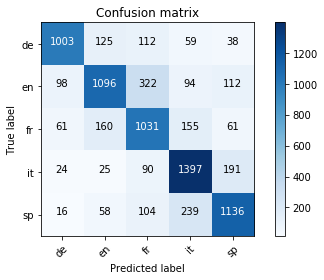

In [82]:
plot_confusion_matrix(cm, languages)

Normalized confusion matrix
[[0.75019 0.09349 0.08377 0.04413 0.02842]
 [0.05691 0.63647 0.18699 0.05459 0.06504]
 [0.04155 0.10899 0.70232 0.10559 0.04155]
 [0.0139  0.01448 0.05211 0.80892 0.1106 ]
 [0.0103  0.03735 0.06697 0.1539  0.73149]]


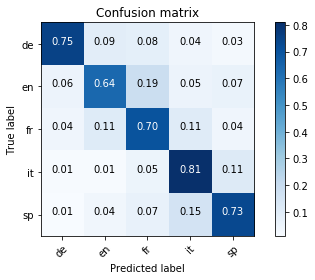

In [83]:
plot_confusion_matrix(cm, languages, normalize=True)